In [ ]:
# Import all required libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import brentq
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.interpolate import griddata
from scipy.interpolate import CloughTocher2DInterpolator
from plotly.subplots import make_subplots
from scipy.optimize import fmin
from scipy.optimize import minimize,least_squares,dual_annealing,differential_evolution
i = complex(0,1)


# Import all functions from custom modules
from Load_data_yfiance import get_data
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from dupire import get_local_vol_surface

In [2]:
spx = yf.Ticker("^SPX")
r = 0.045
Today = "2025-10-16"
calls,option = get_data(Ticker = spx, r = r, Today = Today)
print("number of options: ",calls.size)
calls.head()

number of options:  1079


,strike,lastPrice,lastTradeDate,CP,exp,S0,ttm,exp_month,r,in_out,F,q,imp_vol
70,6555.0,207.56,2025-10-16 15:25:37+00:00,0,2025-11-04,6735.129883,0.075397,2511,0.045,in,6608.37347,0.296994,0.079083
73,6790.0,55.00,2025-10-16 14:23:29+00:00,0,2025-11-04,6735.129883,0.075397,2511,0.045,out,6608.37347,0.296994,0.094360
85,6565.0,200.35,2025-10-16 13:57:44+00:00,0,2025-11-05,6735.129883,0.079365,2511,0.045,in,6608.37347,0.284394,0.079729
107,6725.0,77.98,2025-10-16 16:50:24+00:00,0,2025-11-06,6735.129883,0.083333,2511,0.045,in,6608.37347,0.272995,0.075810
136,6680.0,105.84,2025-10-16 19:28:31+00:00,0,2025-11-11,6735.129883,0.103175,2511,0.045,in,6608.37347,0.229149,0.060438


In [3]:
interp,regres = get_interp(calls)
plot_two_interp(interp,regres,calls)

In [4]:
impvol_interp = interp
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface)


In [5]:
impvol_interp = regres
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface_ = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface_)

In [ ]:
# Exercise price
K = 6000
# time in years
T = 1.0
# number of time steps in simulation
N = 252
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate <---------- need to double check
q = 0
# number of simulations
M = 100

# Extract unique strike prices and times to maturity from the calls DataFrame
strike_arr = np.array(sorted(calls['strike'].unique()))
ttm_arr = np.array(sorted(calls['ttm'].unique()))

# Find index of K in strike array. If not found, use closest.
K_idx = (np.abs(strike_arr - K)).argmin()
# Get the corresponding path (all times for closest K)
V_path = local_vol_surface[K_idx, :]

# V_path = local_vol_surface

In [7]:
v0,kappa,theta,rho,sigma = fit_Heston_model(calls)
print("initial variance under risk-neutral dynamics")
print("v0:", v0)
print("rate of mean reversion of variance under risk-neutral dynamics")
print("kappa:", kappa)
print("long-term mean of variance under risk-neutral dynamics")
print("theta:", theta)
print("correlation between returns and variances under risk-neutral dynamics")
print("rho:", rho)
print("volatility of volatility")
print("sigma:", sigma)

initial variance under risk-neutral dynamics
v0: 0.02
rate of mean reversion of variance under risk-neutral dynamics
kappa: 2.0
long-term mean of variance under risk-neutral dynamics
theta: 0.02
correlation between returns and variances under risk-neutral dynamics
rho: -0.5
volatility of volatility
sigma: 0.02


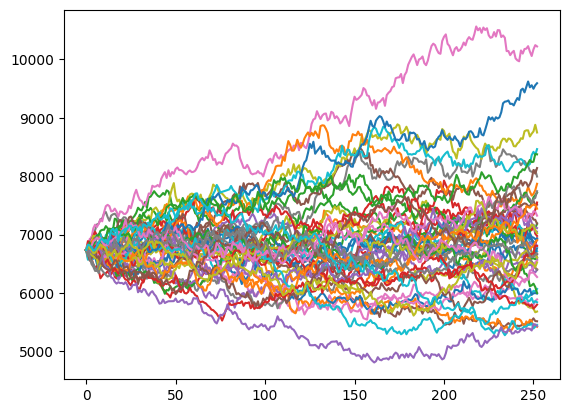

In [8]:
# Exercise price
K = 6000
# time in years
T = 1.0
# number of time steps in simulation
N = 252
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate <---------- need to double check
q = 0
# number of simulations
M = 100

S_path,V_path = heston_simulation(S0=S0,r=r,q=q,K=K,T=T,v0=v0,kappa=kappa,theta=theta,rho=rho,sigma=sigma,paths=M,steps=N)
plt.plot(S_path[:,:50])
plt.show()

In [9]:
def heston_simulation(S0,r,q,K,T,v0,kappa,theta,rho,sigma,paths,steps):
    """
    paths:路径数
    steps：模拟天数
    """
    dt = T/steps
    S_path = np.zeros((steps+1,paths))
    V_path = np.zeros((steps+1,paths))
    S_path[0] = S0
    V_path[0] = v0
    
    for step in range(1,steps+1):
        rn1 = np.random.standard_normal(paths) 
        rn2 = np.random.standard_normal(paths)
        rn2 = rho*rn1 + np.sqrt(1-rho**2)*rn2  #利用cholesky分解，重新赋值rn2确保两个相关系数为rho
        
        S_path[step] = S_path[step - 1] * np.exp((r-q-0.5*V_path[step-1])*dt + np.sqrt(V_path[step-1])*np.sqrt(dt)*rn1) #几何布朗运动的解
        V_path[step] = (np.sqrt(V_path[step - 1]) + sigma/2*np.sqrt(dt)*rn2)**2 + kappa*(theta-V_path[step - 1])*dt - sigma**2/4*dt 
        V_path[step] = np.maximum(V_path[step],0)  #避免v取到负数，和0取大作为结果
        
    value = np.maximum(S_path[-1] - K,0).mean()   
    
    return S_path,V_path,value

In [10]:
def payoff_shark_fin_call(S_array, K, B):
    """
    单步近似：
      若最终价 S_T >= B，则认为障碍被触及 => Payoff = 0
      否则 Payoff = max(S_T - K, 0)
    """
    return np.where(S_array >= B, 0.0, np.maximum(S_array - K, 0.0))